## Introduction

In the after-class quiz, you tackled **univariate time series prediction** using LSTM and Feed-Forward neural networks, where you predicted future values based on a single feature (temperature).

In this homework, you'll advance to **multivariate time series prediction** using LSTM, where you'll predict stock prices using multiple features:

- **Open**: Opening price
- **High**: Highest price of the day
- **Low**: Lowest price of the day  
- **Close**: Closing price (our target)
- **Volume**: Trading volume (log-transformed)

### Key Differences from Univariate:

| Aspect | Univariate | Multivariate |
|--------|-----------|--------------|
| **Input Features** | 1 (e.g., temperature) | 5 (Open, High, Low, Close, Volume) |
| **Complexity** | Simpler patterns | Richer, more complex patterns |
| **Model Capacity** | Can be smaller | Needs more capacity |

### Learning Objectives:

✓ Properly preprocess multivariate time series **without data leakage**  
✓ Build and train an LSTM model for stock price forecasting  
✓ Evaluate model performance using RMSE  
✓ Visualize predictions across train/validation/test sets  

Let's get started! 


## Setup: Import Libraries and Configure Backend

Import necessary libraries and set up the PyTorch backend for Keras.


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error



In [113]:
# Detect operating system and set Keras backend
import os
import platform
import importlib

system = platform.system()
default_backend = "tensorflow" if system == "Darwin" else "torch"

if "KERAS_BACKEND" in os.environ:
    backend = os.environ["KERAS_BACKEND"]
    print(f"Environment override detected: Using {backend.capitalize()} backend")
else:
    backend = default_backend
    print(f"Detected {system}: defaulting to {backend.capitalize()} backend")

module_name = {
    "tensorflow": "tensorflow",
    "torch": "torch",
    "jax": "jax",
}.get(backend, backend)

if importlib.util.find_spec(module_name) is None:
    fallback_backend = "tensorflow"
    if backend != fallback_backend:
        print(f"Warning: Backend {backend!r} requires package {module_name!r}, which is not installed. Falling back to {fallback_backend.capitalize()} backend.")
    backend = fallback_backend

os.environ["KERAS_BACKEND"] = backend
print(f"Final Keras backend: {backend.capitalize()}")



Environment override detected: Using Torch backend
Final Keras backend: Torch


In [114]:
# Check and configure device (GPU/CPU)
def configure_device():
    backend = os.environ.get("KERAS_BACKEND", "tensorflow")

    if backend == "tensorflow":
        import tensorflow as tf
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"GPU available: {len(gpus)} GPU(s) detected")
            print(f"Using GPU: {gpus[0].name}")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    elif backend == "torch":
        try:
            import torch
        except ImportError:
            print("PyTorch backend requested but torch is not installed. Using CPU.")
            return "CPU"
        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f"GPU available: {torch.cuda.get_device_name(0)}")
            print("Using GPU")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    else:
        print(f"Unsupported backend {backend!r}. Using CPU by default.")
        return "CPU"

device_type = configure_device()



No GPU detected. Using CPU


## Load and Explore the Stock Dataset

Load the historical stock price data and perform initial exploration:

- Parse the CSV file
- Log-transform the volume (stabilizes variance)
- Remove redundant 'Adj Close' column
- Sort chronologically by date


In [115]:
# load the dataset
STOCK_CSV = '../datasets/stock.csv'
df = pd.read_csv(STOCK_CSV, header=None, index_col=None, delimiter=',')
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df['Date'] = pd.to_datetime(df['Date'])
df['Volume'] = np.log1p(df['Volume'])
df.drop("Adj Close", axis=1, inplace=True)
print(df.shape)
df.head()



(5035, 6)


,Date,Open,High,Low,Close,Volume
0,1996-12-31,23.011177,23.175543,22.805719,22.928993,14.815849
1,1997-01-02,22.928993,22.970085,21.942801,22.148258,15.909274
2,1997-01-03,22.394806,22.805719,22.394806,22.764629,15.352378
3,1997-01-06,22.764629,22.928993,22.559172,22.682446,15.102896
4,1997-01-07,22.682446,22.682446,22.435898,22.641354,15.098165


In [116]:
# sort the data by date
df = df.sort_values('Date').set_index('Date')
df.head(20)


,Open,High,Low,Close,Volume
Date,,,,,
1996-12-31,23.011177,23.175543,22.805719,22.928993,14.815849
1997-01-02,22.928993,22.970085,21.942801,22.148258,15.909274
1997-01-03,22.394806,22.805719,22.394806,22.764629,15.352378
1997-01-06,22.764629,22.928993,22.559172,22.682446,15.102896
1997-01-07,22.682446,22.682446,22.435898,22.641354,15.098165
1997-01-08,22.641354,22.805719,22.189348,22.312624,14.986568
1997-01-09,22.312624,22.600264,22.107166,22.189348,15.342979
1997-01-10,22.189348,22.312624,21.819527,22.312624,15.479191
1997-01-13,22.312624,22.518080,22.312624,22.353714,15.353087


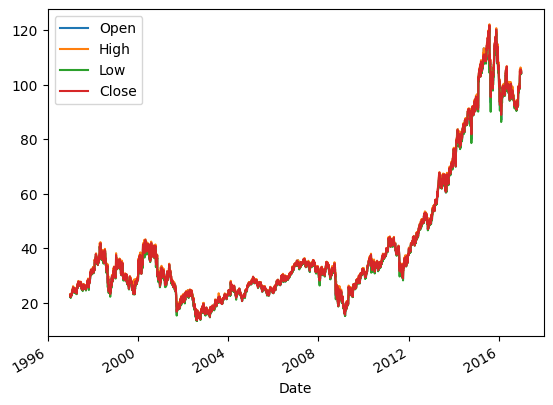

In [117]:
# df_for_plot=df_for_training.tail(5000)

df.drop("Volume",axis=1).plot();


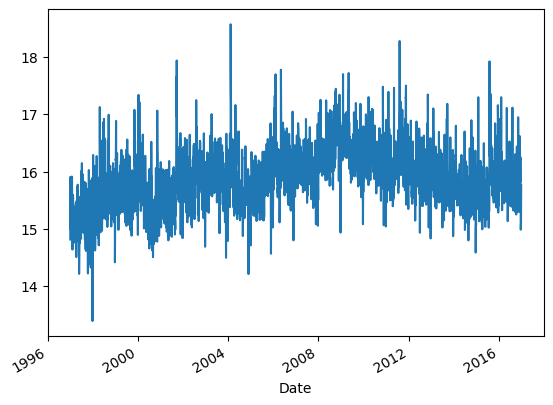

In [118]:
df['Volume'].plot();


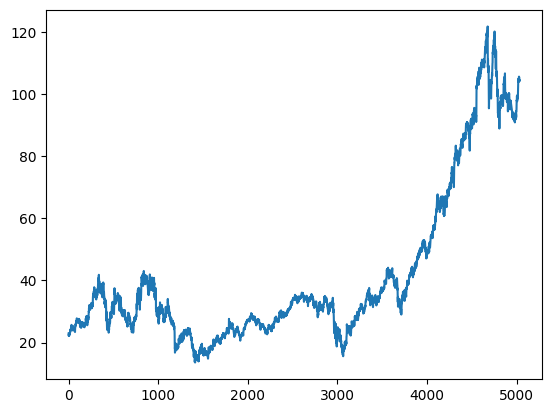

In [119]:
raw_target = df['Close'].values
plt.plot(raw_target);


## Data Preprocessing for Time Series Prediction

**Critical: Preventing Data Leakage**

The correct preprocessing sequence is:

1. **Split first** → Divide dataset into train (70%), validation (15%), and test (15%) sets
2. **Scale with rolling statistics** → Use 100-day rolling mean/std at each time point
3. **Create sliding windows** → Generate sequences for LSTM input

**Why this order matters:**

- ❌ **Wrong**: Using future data in rolling calculations → **Data leakage**
- ✅ **Correct**: At each point, use only historical data available up to that point → **No leakage**

**Scaling Approach:**
- Close price: Scaled using 100-day rolling mean/std computed on historical data up to each point
- At validation/test time, we use all available historical data (including training data)
- This mimics real-world scenario where you have access to all past data
- Other features: Scaled per lookback window to maintain relative patterns

Let's implement this properly:


###  Data Splitting

In [ ]:
# Suppose your DataFrame is named df
n = len(df)

# Compute split indices
train_end = int(0.7 * n)
val_end = int(0.85 * n)  # 70% + 15%

# Split without shuffling (important for time series!)
train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

print(f"Train shape: {train.shape}, Validation shape: {val.shape}, Test shape: {test.shape}")
train.head()

Train shape: (3524, 5), Validation shape: (755, 5), Test shape: (756, 5)


,Open,High,Low,Close,Volume
Date,,,,,
1996-12-31,23.011177,23.175543,22.805719,22.928993,14.815849
1997-01-02,22.928993,22.970085,21.942801,22.148258,15.909274
1997-01-03,22.394806,22.805719,22.394806,22.764629,15.352378
1997-01-06,22.764629,22.928993,22.559172,22.682446,15.102896
1997-01-07,22.682446,22.682446,22.435898,22.641354,15.098165


### Scaling with rolling statistics

In [ ]:
# Apply 100-day rolling mean and std scaling for Close price
# Compute rolling statistics on available historical data at each point to prevent data leakage
window_size = 100

# Combine all historical data chronologically
# At each point in val/test, we use all preceding data (train + history up to that point)
full_close = df['Close'].copy()

# Calculate rolling mean and std on the full historical series
# This ensures that at each validation/test point, we use all available history
rolling_mean_full = full_close.rolling(window=window_size, min_periods=1).mean()
rolling_std_full = full_close.rolling(window=window_size, min_periods=1).std()
rolling_std_full = rolling_std_full.fillna(1.0)  # Handle NaN
rolling_std_full = rolling_std_full.replace(0, 1.0)  # Prevent division by zero

# Extract rolling statistics for each split
rolling_mean_train = rolling_mean_full.loc[train.index]
rolling_std_train = rolling_std_full.loc[train.index]

rolling_mean_val = rolling_mean_full.loc[val.index]
rolling_std_val = rolling_std_full.loc[val.index]

rolling_mean_test = rolling_mean_full.loc[test.index]
rolling_std_test = rolling_std_full.loc[test.index]

# Scale Close price for all datasets using their respective rolling statistics
train_scaled = train.copy()
train_scaled['Close'] = (train['Close'] - rolling_mean_train) / rolling_std_train

val_scaled = val.copy()
val_scaled['Close'] = (val['Close'] - rolling_mean_val) / rolling_std_val

test_scaled = test.copy()
test_scaled['Close'] = (test['Close'] - rolling_mean_test) / rolling_std_test

print(f"Train shape: {train_scaled.shape}, Val shape: {val_scaled.shape}, Test shape: {test_scaled.shape}")
print(f"Rolling window size for scaling: {window_size}")
print(f"Train rolling mean range: [{rolling_mean_train.min():.2f}, {rolling_mean_train.max():.2f}]")
print(f"Val rolling mean range: [{rolling_mean_val.min():.2f}, {rolling_mean_val.max():.2f}]")
print(f"Test rolling mean range: [{rolling_mean_test.min():.2f}, {rolling_mean_test.max():.2f}]")

Train shape: (3524, 5), Val shape: (755, 5), Test shape: (756, 5)
Rolling window size for scaling: 100
Train rolling mean range: [16.26, 39.64]
Val rolling mean range: [33.75, 67.13]
Test rolling mean range: [67.24, 111.59]


In [ ]:
train_scaled.head()

,Open,High,Low,Close,Volume
Date,,,,,
1996-12-31,23.011177,23.175543,22.805719,0.000000,14.815849
1997-01-02,22.928993,22.970085,21.942801,-0.707107,15.909274
1997-01-03,22.394806,22.805719,22.394806,0.366059,15.352378
1997-01-06,22.764629,22.928993,22.559172,0.152052,15.102896
1997-01-07,22.682446,22.682446,22.435898,0.028087,15.098165


### Creating sliding windows


In [12]:
def create_sequences(data, target_col, look_back=5):
    """
    Create sequences for LSTM input.
    Note: Close price is already scaled using 100-day rolling mean/std.
    Other features are scaled per lookback window to maintain their relative patterns.
    """
    values = data.values.astype(np.float32)
    columns = data.columns
    target_idx = columns.get_loc(target_col)
    X, y = [], []

    for end_idx in range(look_back, len(data)):
        window = values[end_idx - look_back:end_idx].copy()
        
        # Scale non-Close features using per-window statistics
        for col_idx in range(window.shape[1]):
            if col_idx != target_idx:  # Skip Close column (already scaled)
                col_mean = window[:, col_idx].mean()
                col_std = window[:, col_idx].std()
                if col_std == 0:
                    col_std = 1.0
                window[:, col_idx] = (window[:, col_idx] - col_mean) / col_std
        
        X.append(window)
        y.append(values[end_idx, target_idx])  # Target is scaled Close price

    return np.array(X), np.array(y)



Uses a 7-day sliding window to build supervised sequences for time-series prediction

In [13]:
look_back = 7
X_train, y_train = create_sequences(train_scaled, target_col='Close', look_back=look_back)
X_val, y_val     = create_sequences(val_scaled, target_col='Close', look_back=look_back)
X_test, y_test   = create_sequences(test_scaled, target_col='Close', look_back=look_back)

print(X_train.shape, y_train.shape)



(3517, 7, 5) (3517,)


## Task 1: Build and Train the LSTM Model

**Objective:**  
Create and train an LSTM model that achieves a **test RMSE ≤ \$2.00**.

### Steps

1. **Define** the LSTM model architecture.  
2. **Compile** the model with an appropriate loss function and optimizer.  
3. **Train** the model using an early stopping callback, allowing a large number of epochs without overfitting.  
4. **Visualize** the training process by plotting the learning curves.  
5. **Generate predictions** on the test data.  
6. **Inverse transform** predictions back to the original price scale.  
7. **Evaluate** model performance using RMSE and MAE on the original scale.

### Tips for Improvement
If your model does not achieve RMSE ≤ \$2.00, consider:

- Increasing the number of LSTM units  
- Adding an additional LSTM layer  
- Tuning the learning rate  
- Adjusting the batch size  
- Exploring other regularization or dropout configurations



## Task 2: Visualize the Forecasting Results

**Objective:**  
Create a comprehensive visualization that compares model predictions with the actual closing prices.

### The plot should include:

- **Actual closing prices** — black line (ground truth)  
- **Training predictions** — blue line (how well the model fits the training data)  
- **Validation predictions** — orange line (generalization during training)  
- **Test predictions** — red line (final performance on unseen data)

### Interpretation guide:
This visualization allows you to evaluate model behavior:

- **Overfitting:** Training predictions are much better than test predictions.  
- **Underfitting:** All predictions deviate significantly from actual values.  
- **Good fit:** Predictions closely track actual prices across all splits.

Your plot should resemble the one in your previous quiz assignment, clearly showing **separated regions** for the training, validation, and test periods.  
Please refer to the shared figure **`stock_forecasting.png`** in the folder for reference.
